In [1]:
# %pip install -r /home/huuquangdang/huu.quang.dang/thesis/deepfake/deepfake_backend/libs/model/CelebV2/requirements.txt

# # Step 1: Uninstall incompatible NumPy version
# %pip uninstall numpy -y
# # Step 2: Install compatible NumPy version (< 2.0.0)
# %pip install "numpy>=1.21.0,<2.0.0"
# # Step 3: Verify NumPy version
# import numpy as np
# print(f"✅ NumPy version: {np.__version__}")
# print(f"Expected: < 2.0.0 (you should see 1.x.x)")

In [2]:
# Built-in
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# TensorFlow / Keras
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, TimeDistributed, GlobalAveragePooling2D, LSTM, Dense, Dropout
)
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Scikit-learn
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
)

2025-10-18 14:11:23.237329: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-18 14:11:23.270732: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-10-18 14:11:23.486940: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-10-18 14:11:23.486974: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-10-18 14:11:23.488501: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to regi

In [3]:
# Define the path to the dataset
base_path = '/home/huuquangdang/huu.quang.dang/thesis/Dataset/facep/faceplus_processed_research_final_2_crop'
categories = ['fake', 'real']

# Initialize a list to hold data
data = []

# Process each category
for category in categories:
    category_path = os.path.join(base_path, category)
    for filename in os.listdir(category_path):
        if filename.endswith('.jpg'):
            try:
                id_part, frame_part = filename.split('_frame_')
                id_ = id_part.split('_')[0]
                frame = frame_part.split('.')[0]
                data.append({
                    'filename': filename,
                    'path': os.path.join(category_path, filename),
                    'id': int(id_),
                    'frame': int(frame),
                    'label': category
                })
            except ValueError:
                continue

# Convert the data to a DataFrame
df = pd.DataFrame(data)

In [4]:
# Đảm bảo đã có df_cropped.csv chứa đường dẫn ảnh đã crop
df['label_id'] = df['label'].map({'fake': 0, 'real': 1})
df


,filename,path,id,frame,label,label_id
0,855_801_frame_0018.jpg,/home/huuquangdang/huu.quang.dang/thesis/Datas...,855,18,fake,0
1,686_696_frame_0024.jpg,/home/huuquangdang/huu.quang.dang/thesis/Datas...,686,24,fake,0
2,664_668_frame_0017.jpg,/home/huuquangdang/huu.quang.dang/thesis/Datas...,664,17,fake,0
3,486_680_frame_0010.jpg,/home/huuquangdang/huu.quang.dang/thesis/Datas...,486,10,fake,0
4,464_463_frame_0005.jpg,/home/huuquangdang/huu.quang.dang/thesis/Datas...,464,5,fake,0
...,...,...,...,...,...,...
59803,140_frame_0025.jpg,/home/huuquangdang/huu.quang.dang/thesis/Datas...,140,25,real,1
59804,937_frame_0007.jpg,/home/huuquangdang/huu.quang.dang/thesis/Datas...,937,7,real,1
59805,092_frame_0001.jpg,/home/huuquangdang/huu.quang.dang/thesis/Datas...,92,1,real,1
59806,736_frame_0018.jpg,/home/huuquangdang/huu.quang.dang/thesis/Datas...,736,18,real,1


In [5]:
df['video_key'] = df['id'].astype(str) + "_" + df['label']

from collections import defaultdict

video_dict = defaultdict(list)
labels = {}

for _, row in df.iterrows():
    key = row['video_key']
    video_dict[key].append(row['path'])
    labels[key] = row['label_id']


In [6]:
# !pip install opencv-python

In [7]:
# Load pre-extracted CSV features for feature fusion
print("📂 Loading pre-extracted OpenFace features from CSV files...")
csv_fake_path = '/home/huuquangdang/huu.quang.dang/thesis/deepfake/deepfake_backend/libs/tools/fake/fpp_fake_v1.csv'
csv_real_path = '/home/huuquangdang/huu.quang.dang/thesis/deepfake/deepfake_backend/libs/tools/real/fpp_real_v1.csv'

df_fake_features = pd.read_csv(csv_fake_path, header=None)
df_real_features = pd.read_csv(csv_real_path, header=None)

# Combine both dataframes
df_all_features = pd.concat([df_fake_features, df_real_features], ignore_index=True)
df_all_features.columns = ['filename'] + [f'feat_{i}' for i in range(df_all_features.shape[1] - 1)]

# Create a dictionary for fast lookup: filename -> features
openface_features = {}
for _, row in df_all_features.iterrows():
    filename = row['filename']
    features = row.iloc[1:].values.astype('float32')
    openface_features[filename] = features

csv_feature_dim = len(features)
print(f"✅ Loaded {len(openface_features)} feature vectors")
print(f"✅ Each vector has {csv_feature_dim} dimensions")
print(f"✅ Feature dictionary ready for 1-to-1 frame mapping")

📂 Loading pre-extracted OpenFace features from CSV files...
✅ Loaded 59808 feature vectors
✅ Each vector has 674 dimensions
✅ Feature dictionary ready for 1-to-1 frame mapping


# 🔬 Model: BiGRU + Multi-Head Self-Attention

This cell implements **BiGRU with Multi-Head Self-Attention mechanism** for improved sequence modeling, while maintaining:
- ✅ Same function names (`VideoSequence`, `build_model`, `hmm_postprocess`)
- ✅ Same 1-to-1 feature fusion (MobileNet + CSV)
- ✅ Same normalization strategy
- ✅ Enhanced with Bidirectional GRU and Multi-Head Self-Attention layer

In [8]:
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import (
    Input, TimeDistributed, GRU, Dropout, Dense, GlobalAveragePooling2D, 
    Concatenate, BatchNormalization, Bidirectional, MultiHeadAttention, LayerNormalization, GlobalAveragePooling1D
    )
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from hmmlearn.hmm import GaussianHMM
from scipy.stats import mode
from sklearn.preprocessing import StandardScaler

# Configuration (same as before)
video_keys = list(video_dict.keys())
video_labels = [labels[k] for k in video_keys]

img_size = (224, 224)
batch_size = 32
epochs = 50
n_splits = 5
sequence_len = 10
results = []
all_histories = []

# Normalize CSV features (same normalization strategy)
print("🔧 Computing CSV feature statistics for normalization...")
all_csv_features = []
for key in video_keys:
    frames = video_dict[key][:sequence_len]
    for path in frames:
        filename = os.path.basename(path)
        if filename in openface_features:
            all_csv_features.append(openface_features[filename])

csv_scaler = StandardScaler()
csv_scaler.fit(all_csv_features)
print(f"✅ CSV feature normalization fitted on {len(all_csv_features)} samples")

# Data generator (SAME NAME, same functionality)
class VideoSequence(tf.keras.utils.Sequence):
    def __init__(self, video_keys, video_dict, labels, batch_size, img_size, sequence_len=10, augment=False):
        self.video_keys = video_keys
        self.video_dict = video_dict
        self.labels = labels
        self.batch_size = batch_size
        self.img_size = img_size
        self.sequence_len = sequence_len
        self.augment = augment
        self.datagen = ImageDataGenerator(
            rescale=1./255,
            rotation_range=15 if augment else 0,
            zoom_range=0.1 if augment else 0,
            horizontal_flip=augment
        )

    def __len__(self):
        return int(np.ceil(len(self.video_keys) / self.batch_size))

    def __getitem__(self, idx):
        batch_keys = self.video_keys[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_X_img, batch_X_csv, batch_y = [], [], []

        for key in batch_keys:
            frames = self.video_dict[key][:self.sequence_len]
            imgs = []
            csv_feats = []
            
            for path in frames:
                # Load and process image
                img = cv2.imread(path)
                img = cv2.resize(img, self.img_size)
                img = self.datagen.random_transform(img) if self.augment else img
                img = img.astype('float32') / 255.0
                imgs.append(img)
                
                # Load CSV features and normalize (1-to-1 mapping)
                filename = os.path.basename(path)
                if filename in openface_features:
                    csv_feat = openface_features[filename]
                    csv_feat = csv_scaler.transform([csv_feat])[0]
                else:
                    csv_feat = np.zeros(csv_feature_dim, dtype='float32')
                csv_feats.append(csv_feat)
            
            # Pad sequences if needed
            while len(imgs) < self.sequence_len:
                imgs.append(np.zeros((*self.img_size, 3), dtype='float32'))
                csv_feats.append(np.zeros(csv_feature_dim, dtype='float32'))
            
            batch_X_img.append(imgs)
            batch_X_csv.append(csv_feats)
            batch_y.append(self.labels[key])

        return [np.array(batch_X_img), np.array(batch_X_csv)], np.array(batch_y)

# BiGRU + Multi-Head Self-Attention Model (NO KAN)
def build_model(sequence_len, img_size, csv_dim=674):
    # MobileNet branch
    base_cnn = MobileNetV2(input_shape=(*img_size, 3), include_top=False, weights='imagenet')
    base_cnn.trainable = True
    for layer in base_cnn.layers[:-20]:
        layer.trainable = False
    
    cnn_out = GlobalAveragePooling2D()(base_cnn.output)
    cnn_model = Model(inputs=base_cnn.input, outputs=cnn_out)
    
    # Image sequence input
    input_seq_img = Input(shape=(sequence_len, *img_size, 3), name='image_input')
    x_img = TimeDistributed(cnn_model)(input_seq_img)
    
    # CSV features input
    input_seq_csv = Input(shape=(sequence_len, csv_dim), name='csv_input')
    
    # BatchNormalization before fusion
    x_img = BatchNormalization(name='bn_mobilenet')(x_img)
    x_csv = BatchNormalization(name='bn_csv')(input_seq_csv)
    
    # Concatenate features (1-to-1 fusion)
    x_combined = Concatenate(axis=-1, name='feature_fusion')([x_img, x_csv])
    
    # BiGRU layers (Bidirectional GRU)
    x = Bidirectional(GRU(128, return_sequences=True, name='bigru_1'))(x_combined)
    x = Dropout(0.3, name='dropout_1')(x)
    x = Bidirectional(GRU(64, return_sequences=True, name='bigru_2'))(x)
    x = Dropout(0.3, name='dropout_2')(x)
    
    # Multi-Head Self-Attention mechanism
    x_norm = LayerNormalization(name='ln_before_attention')(x)
    attn_output = MultiHeadAttention(
        num_heads=4, 
        key_dim=32, 
        name='multi_head_attention'
    )(x_norm, x_norm)
    
    # Residual connection + Layer normalization
    x = tf.keras.layers.Add(name='residual_connection')([x, attn_output])
    x = LayerNormalization(name='ln_after_attention')(x)
    
    # Global average pooling over time dimension to get fixed-size output
    x = GlobalAveragePooling1D(name='global_avg_pool')(x)
    x = Dropout(0.2, name='dropout_attention')(x)
    
    # Classification layers (NO KAN)
    x = Dense(64, activation='relu', name='dense_1')(x)
    x = Dropout(0.2, name='dropout_3')(x)
    x = Dense(32, activation='relu', name='dense_2')(x)
    x = Dropout(0.2, name='dropout_4')(x)
    
    output = Dense(1, activation='sigmoid', name='output')(x)
    
    model = Model(inputs=[input_seq_img, input_seq_csv], outputs=output, name='BiGRU_MultiHeadAttn')
    return model

# HMM post-processing (SAME NAME, unchanged)
def hmm_postprocess(pred_probs, y_true, n_states=2):
    pred_probs = pred_probs.reshape(-1, 1)
    hmm = GaussianHMM(n_components=n_states, covariance_type="diag", n_iter=100)
    hmm.fit(pred_probs)
    hidden_states = hmm.predict(pred_probs)

    mapping = {}
    for state in np.unique(hidden_states):
        indices = [i for i in range(len(hidden_states)) if hidden_states[i] == state]
        state_labels = [y_true[i] for i in indices]
        if len(state_labels) > 0:
            mapped_label = mode(state_labels, keepdims=True).mode[0]
        else:
            mapped_label = 0
        mapping[state] = mapped_label

    hmm_labels = np.array([mapping[s] for s in hidden_states])
    return hmm_labels

# Training K-Fold
print("\n🚀 Starting BiGRU + Multi-Head Self-Attention Training (NO KAN):")
print("   ✅ Bidirectional GRU (128 + 64 units)")
print("   ✅ Multi-Head Self-Attention (4 heads, 32 key_dim)")
print("   ✅ Residual connections + Layer Normalization")
print("   ✅ Normalized CSV features (1-to-1 mapping)")
print("   ✅ MobileNet (last 20 layers trainable)")
print("   ✅ HMM post-processing\n")

skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

for fold, (trainval_idx, test_idx) in enumerate(skf.split(video_keys, video_labels), 1):
    print(f"\n{'='*60}")
    print(f"📊 Fold {fold}/{n_splits} - BiGRU_MultiHeadAttn")
    print(f"{'='*60}")

    trainval_keys = [video_keys[i] for i in trainval_idx]
    test_keys = [video_keys[i] for i in test_idx]

    y_trainval = [labels[k] for k in trainval_keys]
    train_keys, val_keys = train_test_split(trainval_keys, test_size=0.1, stratify=y_trainval, random_state=fold)

    train_gen = VideoSequence(train_keys, video_dict, labels, batch_size, img_size, sequence_len, augment=True)
    val_gen = VideoSequence(val_keys, video_dict, labels, batch_size, img_size, sequence_len, augment=False)
    test_gen = VideoSequence(test_keys, video_dict, labels, batch_size, img_size, sequence_len, augment=False)

    model = build_model(sequence_len, img_size, csv_feature_dim)
    model.compile(optimizer=Adamax(3e-4), loss='binary_crossentropy', metrics=['accuracy'])
    
    print(f"\n📈 Model Architecture:")
    print(f"   - Model: BiGRU + Multi-Head Self-Attention (NO KAN)")
    print(f"   - Total params: {model.count_params():,}")
    trainable_params = sum([tf.size(w).numpy() for w in model.trainable_weights])
    print(f"   - Trainable params: {trainable_params:,}")
    print(f"   - BiGRU: 128 + 64 units (bidirectional)")
    print(f"   - Multi-Head Attention: 4 heads, 32 key_dim")
    print(f"   - Learning rate: 3e-4")

    model_path = f"best_model_fold{fold}_bigru_mhattn.h5"
    checkpoint = ModelCheckpoint(model_path, monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
    earlystop = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)

    history = model.fit(train_gen, validation_data=val_gen, epochs=epochs,
                        callbacks=[checkpoint, earlystop, reduce_lr], verbose=1)
    all_histories.append(history.history)

    model.load_weights(model_path)

    y_true = [labels[k] for k in test_keys]
    y_pred_prob = model.predict(test_gen).ravel()
    y_hmm_pred = hmm_postprocess(y_pred_prob, y_true)

    results.append({
        'fold': fold,
        'accuracy': accuracy_score(y_true, y_hmm_pred),
        'precision': precision_score(y_true, y_hmm_pred),
        'recall': recall_score(y_true, y_hmm_pred),
        'f1': f1_score(y_true, y_hmm_pred),
        'auc': roc_auc_score(y_true, y_pred_prob)
    })
    
    print(f"\n✅ Fold {fold} Results (BiGRU_MultiHeadAttn):")
    print(f"   Accuracy:  {results[-1]['accuracy']:.4f}")
    print(f"   Precision: {results[-1]['precision']:.4f}")
    print(f"   Recall:    {results[-1]['recall']:.4f}")
    print(f"   F1 Score:  {results[-1]['f1']:.4f}")
    print(f"   AUC:       {results[-1]['auc']:.4f}")

print(f"\n{'='*60}")
print("📊 FINAL RESULTS - BiGRU_MultiHeadAttn Model (NO KAN)")
print(f"{'='*60}")
for r in results:
    print(f"Fold {r['fold']}: Acc={r['accuracy']:.4f}, Prec={r['precision']:.4f}, Rec={r['recall']:.4f}, F1={r['f1']:.4f}, AUC={r['auc']:.4f}")

print(f"\n📊 Average Metrics:")
results_df = pd.DataFrame(results)
print(results_df.mean(numeric_only=True))

🔧 Computing CSV feature statistics for normalization...
✅ CSV feature normalization fitted on 19982 samples

🚀 Starting BiGRU + Multi-Head Self-Attention Training (NO KAN):
   ✅ Bidirectional GRU (128 + 64 units)
   ✅ Multi-Head Self-Attention (4 heads, 32 key_dim)
   ✅ Residual connections + Layer Normalization
   ✅ Normalized CSV features (1-to-1 mapping)
   ✅ MobileNet (last 20 layers trainable)
   ✅ HMM post-processing


📊 Fold 1/5 - BiGRU_MultiHeadAttn

📈 Model Architecture:
   - Model: BiGRU + Multi-Head Self-Attention (NO KAN)
   - Total params: 4,066,889
   - Trainable params: 3,011,077
   - BiGRU: 128 + 64 units (bidirectional)
   - Multi-Head Attention: 4 heads, 32 key_dim
   - Learning rate: 3e-4
Epoch 1/50
45/45 [==============================] - ETA: 0s - loss: 0.6028 - accuracy: 0.6875
Epoch 1: val_accuracy improved from -inf to 0.71875, saving model to best_model_fold1_bigru_mhattn.h5
45/45 [==============================] - 165s 4s/step - loss: 0.6028 - accuracy: 0.6875

/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


45/45 [==============================] - ETA: 0s - loss: 0.3999 - accuracy: 0.8229
Epoch 2: val_accuracy improved from 0.71875 to 0.76875, saving model to best_model_fold1_bigru_mhattn.h5
45/45 [==============================] - 146s 3s/step - loss: 0.3999 - accuracy: 0.8229 - val_loss: 0.4640 - val_accuracy: 0.7688 - lr: 3.0000e-04
Epoch 3/50


/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


45/45 [==============================] - ETA: 0s - loss: 0.2759 - accuracy: 0.8847
Epoch 3: val_accuracy improved from 0.76875 to 0.79375, saving model to best_model_fold1_bigru_mhattn.h5
45/45 [==============================] - 145s 3s/step - loss: 0.2759 - accuracy: 0.8847 - val_loss: 0.4376 - val_accuracy: 0.7937 - lr: 3.0000e-04
Epoch 4/50


/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


45/45 [==============================] - ETA: 0s - loss: 0.1953 - accuracy: 0.9250
Epoch 4: val_accuracy improved from 0.79375 to 0.81875, saving model to best_model_fold1_bigru_mhattn.h5
45/45 [==============================] - 145s 3s/step - loss: 0.1953 - accuracy: 0.9250 - val_loss: 0.4358 - val_accuracy: 0.8188 - lr: 3.0000e-04
Epoch 5/50


/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


45/45 [==============================] - ETA: 0s - loss: 0.1452 - accuracy: 0.9535
Epoch 5: val_accuracy did not improve from 0.81875
45/45 [==============================] - 145s 3s/step - loss: 0.1452 - accuracy: 0.9535 - val_loss: 0.4607 - val_accuracy: 0.7875 - lr: 3.0000e-04
Epoch 6/50
45/45 [==============================] - ETA: 0s - loss: 0.1011 - accuracy: 0.9667
Epoch 6: val_accuracy improved from 0.81875 to 0.82500, saving model to best_model_fold1_bigru_mhattn.h5
45/45 [==============================] - 144s 3s/step - loss: 0.1011 - accuracy: 0.9667 - val_loss: 0.4744 - val_accuracy: 0.8250 - lr: 3.0000e-04
Epoch 7/50


/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


45/45 [==============================] - ETA: 0s - loss: 0.0862 - accuracy: 0.9722
Epoch 7: val_accuracy improved from 0.82500 to 0.86250, saving model to best_model_fold1_bigru_mhattn.h5
45/45 [==============================] - 146s 3s/step - loss: 0.0862 - accuracy: 0.9722 - val_loss: 0.4344 - val_accuracy: 0.8625 - lr: 3.0000e-04
Epoch 8/50


/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


45/45 [==============================] - ETA: 0s - loss: 0.0553 - accuracy: 0.9854
Epoch 8: val_accuracy did not improve from 0.86250
45/45 [==============================] - 143s 3s/step - loss: 0.0553 - accuracy: 0.9854 - val_loss: 0.6964 - val_accuracy: 0.8188 - lr: 3.0000e-04
Epoch 9/50
45/45 [==============================] - ETA: 0s - loss: 0.0361 - accuracy: 0.9889
Epoch 9: val_accuracy did not improve from 0.86250
45/45 [==============================] - 144s 3s/step - loss: 0.0361 - accuracy: 0.9889 - val_loss: 0.7452 - val_accuracy: 0.8313 - lr: 3.0000e-04
Epoch 10/50
45/45 [==============================] - ETA: 0s - loss: 0.0327 - accuracy: 0.9951
Epoch 10: val_accuracy did not improve from 0.86250

Epoch 10: ReduceLROnPlateau reducing learning rate to 0.0001500000071246177.
45/45 [==============================] - 144s 3s/step - loss: 0.0327 - accuracy: 0.9951 - val_loss: 0.7008 - val_accuracy: 0.8438 - lr: 3.0000e-04
Epoch 11/50
45/45 [==============================] - ET

/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


45/45 [==============================] - ETA: 0s - loss: 0.0123 - accuracy: 0.9979
Epoch 13: val_accuracy did not improve from 0.88750

Epoch 13: ReduceLROnPlateau reducing learning rate to 7.500000356230885e-05.
45/45 [==============================] - 145s 3s/step - loss: 0.0123 - accuracy: 0.9979 - val_loss: 0.6043 - val_accuracy: 0.8875 - lr: 1.5000e-04
Epoch 14/50
45/45 [==============================] - ETA: 0s - loss: 0.0116 - accuracy: 0.9986
Epoch 14: val_accuracy did not improve from 0.88750
45/45 [==============================] - 145s 3s/step - loss: 0.0116 - accuracy: 0.9986 - val_loss: 0.6467 - val_accuracy: 0.8813 - lr: 7.5000e-05
Epoch 15/50
45/45 [==============================] - ETA: 0s - loss: 0.0124 - accuracy: 0.9979
Epoch 15: val_accuracy did not improve from 0.88750
45/45 [==============================] - 143s 3s/step - loss: 0.0124 - accuracy: 0.9979 - val_loss: 0.7009 - val_accuracy: 0.8750 - lr: 7.5000e-05
Epoch 16/50
45/45 [==============================] -

/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


45/45 [==============================] - ETA: 0s - loss: 0.3762 - accuracy: 0.8410
Epoch 2: val_accuracy improved from 0.62500 to 0.78125, saving model to best_model_fold2_bigru_mhattn.h5
45/45 [==============================] - 145s 3s/step - loss: 0.3762 - accuracy: 0.8410 - val_loss: 0.4621 - val_accuracy: 0.7812 - lr: 3.0000e-04
Epoch 3/50


/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


45/45 [==============================] - ETA: 0s - loss: 0.2711 - accuracy: 0.8931
Epoch 3: val_accuracy did not improve from 0.78125
45/45 [==============================] - 146s 3s/step - loss: 0.2711 - accuracy: 0.8931 - val_loss: 0.4457 - val_accuracy: 0.7750 - lr: 3.0000e-04
Epoch 4/50
45/45 [==============================] - ETA: 0s - loss: 0.1898 - accuracy: 0.9326
Epoch 4: val_accuracy did not improve from 0.78125
45/45 [==============================] - 146s 3s/step - loss: 0.1898 - accuracy: 0.9326 - val_loss: 0.4699 - val_accuracy: 0.7625 - lr: 3.0000e-04
Epoch 5/50
45/45 [==============================] - ETA: 0s - loss: 0.1315 - accuracy: 0.9563
Epoch 5: val_accuracy improved from 0.78125 to 0.80000, saving model to best_model_fold2_bigru_mhattn.h5
45/45 [==============================] - 146s 3s/step - loss: 0.1315 - accuracy: 0.9563 - val_loss: 0.5380 - val_accuracy: 0.8000 - lr: 3.0000e-04
Epoch 6/50


/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


45/45 [==============================] - ETA: 0s - loss: 0.0982 - accuracy: 0.9674
Epoch 6: val_accuracy did not improve from 0.80000

Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0001500000071246177.
45/45 [==============================] - 144s 3s/step - loss: 0.0982 - accuracy: 0.9674 - val_loss: 0.5744 - val_accuracy: 0.8000 - lr: 3.0000e-04
Epoch 7/50
45/45 [==============================] - ETA: 0s - loss: 0.0584 - accuracy: 0.9840
Epoch 7: val_accuracy did not improve from 0.80000
45/45 [==============================] - 144s 3s/step - loss: 0.0584 - accuracy: 0.9840 - val_loss: 0.7235 - val_accuracy: 0.7875 - lr: 1.5000e-04
Epoch 8/50
45/45 [==============================] - ETA: 0s - loss: 0.0502 - accuracy: 0.9896
Epoch 8: val_accuracy improved from 0.80000 to 0.81250, saving model to best_model_fold2_bigru_mhattn.h5
45/45 [==============================] - 144s 3s/step - loss: 0.0502 - accuracy: 0.9896 - val_loss: 0.6637 - val_accuracy: 0.8125 - lr: 1.5000e-04
Epoc

/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


45/45 [==============================] - ETA: 0s - loss: 0.0375 - accuracy: 0.9924
Epoch 9: val_accuracy did not improve from 0.81250

Epoch 9: ReduceLROnPlateau reducing learning rate to 7.500000356230885e-05.
45/45 [==============================] - 145s 3s/step - loss: 0.0375 - accuracy: 0.9924 - val_loss: 0.8434 - val_accuracy: 0.8062 - lr: 1.5000e-04
Epoch 10/50
45/45 [==============================] - ETA: 0s - loss: 0.0294 - accuracy: 0.9958
Epoch 10: val_accuracy did not improve from 0.81250
45/45 [==============================] - 145s 3s/step - loss: 0.0294 - accuracy: 0.9958 - val_loss: 0.7428 - val_accuracy: 0.8125 - lr: 7.5000e-05
Epoch 11/50
45/45 [==============================] - ETA: 0s - loss: 0.0280 - accuracy: 0.9972
Epoch 11: val_accuracy improved from 0.81250 to 0.82500, saving model to best_model_fold2_bigru_mhattn.h5
45/45 [==============================] - 146s 3s/step - loss: 0.0280 - accuracy: 0.9972 - val_loss: 0.7151 - val_accuracy: 0.8250 - lr: 7.5000e-05


/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


45/45 [==============================] - ETA: 0s - loss: 0.0257 - accuracy: 0.9951
Epoch 12: val_accuracy improved from 0.82500 to 0.84375, saving model to best_model_fold2_bigru_mhattn.h5

Epoch 12: ReduceLROnPlateau reducing learning rate to 3.7500001781154424e-05.
45/45 [==============================] - 146s 3s/step - loss: 0.0257 - accuracy: 0.9951 - val_loss: 0.6609 - val_accuracy: 0.8438 - lr: 7.5000e-05
Epoch 13/50


/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


45/45 [==============================] - ETA: 0s - loss: 0.0223 - accuracy: 0.9958
Epoch 13: val_accuracy did not improve from 0.84375
45/45 [==============================] - 143s 3s/step - loss: 0.0223 - accuracy: 0.9958 - val_loss: 0.6806 - val_accuracy: 0.8313 - lr: 3.7500e-05
Epoch 14/50
45/45 [==============================] - ETA: 0s - loss: 0.0202 - accuracy: 0.9965
Epoch 14: val_accuracy did not improve from 0.84375
45/45 [==============================] - 143s 3s/step - loss: 0.0202 - accuracy: 0.9965 - val_loss: 0.7019 - val_accuracy: 0.8250 - lr: 3.7500e-05
Epoch 15/50
45/45 [==============================] - ETA: 0s - loss: 0.0205 - accuracy: 0.9979
Epoch 15: val_accuracy did not improve from 0.84375

Epoch 15: ReduceLROnPlateau reducing learning rate to 1.8750000890577212e-05.
45/45 [==============================] - 144s 3s/step - loss: 0.0205 - accuracy: 0.9979 - val_loss: 0.7005 - val_accuracy: 0.8313 - lr: 3.7500e-05
Epoch 16/50
45/45 [==============================] 

/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


45/45 [==============================] - ETA: 0s - loss: 0.4156 - accuracy: 0.8111
Epoch 2: val_accuracy improved from 0.68125 to 0.72500, saving model to best_model_fold3_bigru_mhattn.h5


/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


45/45 [==============================] - 144s 3s/step - loss: 0.4156 - accuracy: 0.8111 - val_loss: 0.5034 - val_accuracy: 0.7250 - lr: 3.0000e-04
Epoch 3/50
45/45 [==============================] - ETA: 0s - loss: 0.2917 - accuracy: 0.8757
Epoch 3: val_accuracy improved from 0.72500 to 0.73125, saving model to best_model_fold3_bigru_mhattn.h5
45/45 [==============================] - 144s 3s/step - loss: 0.2917 - accuracy: 0.8757 - val_loss: 0.4944 - val_accuracy: 0.7312 - lr: 3.0000e-04
Epoch 4/50


/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


45/45 [==============================] - ETA: 0s - loss: 0.2204 - accuracy: 0.9160
Epoch 4: val_accuracy improved from 0.73125 to 0.77500, saving model to best_model_fold3_bigru_mhattn.h5
45/45 [==============================] - 143s 3s/step - loss: 0.2204 - accuracy: 0.9160 - val_loss: 0.5070 - val_accuracy: 0.7750 - lr: 3.0000e-04
Epoch 5/50


/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


45/45 [==============================] - ETA: 0s - loss: 0.1668 - accuracy: 0.9396
Epoch 5: val_accuracy improved from 0.77500 to 0.78125, saving model to best_model_fold3_bigru_mhattn.h5
45/45 [==============================] - 144s 3s/step - loss: 0.1668 - accuracy: 0.9396 - val_loss: 0.5223 - val_accuracy: 0.7812 - lr: 3.0000e-04
Epoch 6/50


/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


45/45 [==============================] - ETA: 0s - loss: 0.1243 - accuracy: 0.9583
Epoch 6: val_accuracy improved from 0.78125 to 0.78750, saving model to best_model_fold3_bigru_mhattn.h5


/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0001500000071246177.
45/45 [==============================] - 144s 3s/step - loss: 0.1243 - accuracy: 0.9583 - val_loss: 0.5252 - val_accuracy: 0.7875 - lr: 3.0000e-04
Epoch 7/50
45/45 [==============================] - ETA: 0s - loss: 0.0797 - accuracy: 0.9799
Epoch 7: val_accuracy did not improve from 0.78750
45/45 [==============================] - 148s 3s/step - loss: 0.0797 - accuracy: 0.9799 - val_loss: 0.6558 - val_accuracy: 0.7875 - lr: 1.5000e-04
Epoch 8/50
45/45 [==============================] - ETA: 0s - loss: 0.0609 - accuracy: 0.9854
Epoch 8: val_accuracy did not improve from 0.78750
45/45 [==============================] - 148s 3s/step - loss: 0.0609 - accuracy: 0.9854 - val_loss: 0.5951 - val_accuracy: 0.7875 - lr: 1.5000e-04
Epoch 9/50
45/45 [==============================] - ETA: 0s - loss: 0.0639 - accuracy: 0.9847
Epoch 9: val_accuracy improved from 0.78750 to 0.81250, saving model to best_model_fold3_bigru_mha

/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


45/45 [==============================] - ETA: 0s - loss: 0.0476 - accuracy: 0.9917
Epoch 10: val_accuracy did not improve from 0.81250
45/45 [==============================] - 146s 3s/step - loss: 0.0476 - accuracy: 0.9917 - val_loss: 0.7386 - val_accuracy: 0.8125 - lr: 7.5000e-05
Epoch 11/50
45/45 [==============================] - ETA: 0s - loss: 0.0386 - accuracy: 0.9951
Epoch 11: val_accuracy did not improve from 0.81250
45/45 [==============================] - 145s 3s/step - loss: 0.0386 - accuracy: 0.9951 - val_loss: 0.7261 - val_accuracy: 0.8062 - lr: 7.5000e-05
Epoch 12/50
45/45 [==============================] - ETA: 0s - loss: 0.0382 - accuracy: 0.9951
Epoch 12: val_accuracy improved from 0.81250 to 0.82500, saving model to best_model_fold3_bigru_mhattn.h5

Epoch 12: ReduceLROnPlateau reducing learning rate to 3.7500001781154424e-05.
45/45 [==============================] - 145s 3s/step - loss: 0.0382 - accuracy: 0.9951 - val_loss: 0.7169 - val_accuracy: 0.8250 - lr: 7.5000e-

/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


45/45 [==============================] - ETA: 0s - loss: 0.0335 - accuracy: 0.9972
Epoch 13: val_accuracy did not improve from 0.82500
45/45 [==============================] - 143s 3s/step - loss: 0.0335 - accuracy: 0.9972 - val_loss: 0.7049 - val_accuracy: 0.8188 - lr: 3.7500e-05
Epoch 14/50
45/45 [==============================] - ETA: 0s - loss: 0.0308 - accuracy: 0.9965
Epoch 14: val_accuracy did not improve from 0.82500
45/45 [==============================] - 144s 3s/step - loss: 0.0308 - accuracy: 0.9965 - val_loss: 0.6946 - val_accuracy: 0.8125 - lr: 3.7500e-05
Epoch 15/50
45/45 [==============================] - ETA: 0s - loss: 0.0310 - accuracy: 0.9972
Epoch 15: val_accuracy did not improve from 0.82500

Epoch 15: ReduceLROnPlateau reducing learning rate to 1.8750000890577212e-05.
45/45 [==============================] - 144s 3s/step - loss: 0.0310 - accuracy: 0.9972 - val_loss: 0.6854 - val_accuracy: 0.8062 - lr: 3.7500e-05
Epoch 16/50
45/45 [==============================] 

/home/huuquangdang/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])



📈 Model Architecture:
   - Model: BiGRU + Multi-Head Self-Attention (NO KAN)
   - Total params: 4,066,889
   - Trainable params: 3,011,077
   - BiGRU: 128 + 64 units (bidirectional)
   - Multi-Head Attention: 4 heads, 32 key_dim
   - Learning rate: 3e-4
Epoch 1/50
45/45 [==============================] - ETA: 0s - loss: 0.5689 - accuracy: 0.7028
Epoch 1: val_accuracy improved from -inf to 0.66875, saving model to best_model_fold4_bigru_mhattn.h5
45/45 [==============================] - 149s 3s/step - loss: 0.5689 - accuracy: 0.7028 - val_loss: 0.5958 - val_accuracy: 0.6687 - lr: 3.0000e-04
Epoch 2/50


/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


45/45 [==============================] - ETA: 0s - loss: 0.3628 - accuracy: 0.8424
Epoch 2: val_accuracy improved from 0.66875 to 0.68750, saving model to best_model_fold4_bigru_mhattn.h5
45/45 [==============================] - 144s 3s/step - loss: 0.3628 - accuracy: 0.8424 - val_loss: 0.5776 - val_accuracy: 0.6875 - lr: 3.0000e-04
Epoch 3/50


/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


45/45 [==============================] - ETA: 0s - loss: 0.2587 - accuracy: 0.9062
Epoch 3: val_accuracy improved from 0.68750 to 0.81875, saving model to best_model_fold4_bigru_mhattn.h5
45/45 [==============================] - 144s 3s/step - loss: 0.2587 - accuracy: 0.9062 - val_loss: 0.3941 - val_accuracy: 0.8188 - lr: 3.0000e-04
Epoch 4/50


/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


45/45 [==============================] - ETA: 0s - loss: 0.1829 - accuracy: 0.9368
Epoch 4: val_accuracy did not improve from 0.81875
45/45 [==============================] - 145s 3s/step - loss: 0.1829 - accuracy: 0.9368 - val_loss: 0.4717 - val_accuracy: 0.7750 - lr: 3.0000e-04
Epoch 5/50
45/45 [==============================] - ETA: 0s - loss: 0.1285 - accuracy: 0.9569
Epoch 5: val_accuracy improved from 0.81875 to 0.84375, saving model to best_model_fold4_bigru_mhattn.h5
45/45 [==============================] - 144s 3s/step - loss: 0.1285 - accuracy: 0.9569 - val_loss: 0.4199 - val_accuracy: 0.8438 - lr: 3.0000e-04
Epoch 6/50


/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


45/45 [==============================] - ETA: 0s - loss: 0.0916 - accuracy: 0.9681
Epoch 6: val_accuracy did not improve from 0.84375

Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0001500000071246177.
45/45 [==============================] - 144s 3s/step - loss: 0.0916 - accuracy: 0.9681 - val_loss: 0.4747 - val_accuracy: 0.8125 - lr: 3.0000e-04
Epoch 7/50
45/45 [==============================] - ETA: 0s - loss: 0.0672 - accuracy: 0.9757
Epoch 7: val_accuracy did not improve from 0.84375
45/45 [==============================] - 144s 3s/step - loss: 0.0672 - accuracy: 0.9757 - val_loss: 0.4307 - val_accuracy: 0.8250 - lr: 1.5000e-04
Epoch 8/50
45/45 [==============================] - ETA: 0s - loss: 0.0538 - accuracy: 0.9889
Epoch 8: val_accuracy did not improve from 0.84375
45/45 [==============================] - 144s 3s/step - loss: 0.0538 - accuracy: 0.9889 - val_loss: 0.4374 - val_accuracy: 0.8375 - lr: 1.5000e-04
Epoch 9/50
45/45 [==============================] - ETA: 0

/home/huuquangdang/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])



📈 Model Architecture:
   - Model: BiGRU + Multi-Head Self-Attention (NO KAN)
   - Total params: 4,066,889
   - Trainable params: 3,011,077
   - BiGRU: 128 + 64 units (bidirectional)
   - Multi-Head Attention: 4 heads, 32 key_dim
   - Learning rate: 3e-4
Epoch 1/50
45/45 [==============================] - ETA: 0s - loss: 0.6822 - accuracy: 0.6201
Epoch 1: val_accuracy improved from -inf to 0.55000, saving model to best_model_fold5_bigru_mhattn.h5
45/45 [==============================] - 149s 3s/step - loss: 0.6822 - accuracy: 0.6201 - val_loss: 0.7609 - val_accuracy: 0.5500 - lr: 3.0000e-04
Epoch 2/50


/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


45/45 [==============================] - ETA: 0s - loss: 0.4469 - accuracy: 0.7778
Epoch 2: val_accuracy improved from 0.55000 to 0.63125, saving model to best_model_fold5_bigru_mhattn.h5
45/45 [==============================] - 146s 3s/step - loss: 0.4469 - accuracy: 0.7778 - val_loss: 0.8009 - val_accuracy: 0.6313 - lr: 3.0000e-04
Epoch 3/50


/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


45/45 [==============================] - ETA: 0s - loss: 0.3388 - accuracy: 0.8514
Epoch 3: val_accuracy improved from 0.63125 to 0.71875, saving model to best_model_fold5_bigru_mhattn.h5
45/45 [==============================] - 149s 3s/step - loss: 0.3388 - accuracy: 0.8514 - val_loss: 0.6879 - val_accuracy: 0.7188 - lr: 3.0000e-04
Epoch 4/50


/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


45/45 [==============================] - ETA: 0s - loss: 0.2447 - accuracy: 0.9021
Epoch 4: val_accuracy improved from 0.71875 to 0.81250, saving model to best_model_fold5_bigru_mhattn.h5


/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


45/45 [==============================] - 149s 3s/step - loss: 0.2447 - accuracy: 0.9021 - val_loss: 0.4210 - val_accuracy: 0.8125 - lr: 3.0000e-04
Epoch 5/50
45/45 [==============================] - ETA: 0s - loss: 0.1664 - accuracy: 0.9438
Epoch 5: val_accuracy improved from 0.81250 to 0.83750, saving model to best_model_fold5_bigru_mhattn.h5
45/45 [==============================] - 145s 3s/step - loss: 0.1664 - accuracy: 0.9438 - val_loss: 0.4656 - val_accuracy: 0.8375 - lr: 3.0000e-04
Epoch 6/50


/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


45/45 [==============================] - ETA: 0s - loss: 0.1235 - accuracy: 0.9583
Epoch 6: val_accuracy did not improve from 0.83750
45/45 [==============================] - 144s 3s/step - loss: 0.1235 - accuracy: 0.9583 - val_loss: 0.6870 - val_accuracy: 0.8000 - lr: 3.0000e-04
Epoch 7/50
45/45 [==============================] - ETA: 0s - loss: 0.0890 - accuracy: 0.9736
Epoch 7: val_accuracy did not improve from 0.83750

Epoch 7: ReduceLROnPlateau reducing learning rate to 0.0001500000071246177.
45/45 [==============================] - 144s 3s/step - loss: 0.0890 - accuracy: 0.9736 - val_loss: 1.0255 - val_accuracy: 0.7625 - lr: 3.0000e-04
Epoch 8/50
45/45 [==============================] - ETA: 0s - loss: 0.0560 - accuracy: 0.9868
Epoch 8: val_accuracy did not improve from 0.83750
45/45 [==============================] - 150s 3s/step - loss: 0.0560 - accuracy: 0.9868 - val_loss: 0.5950 - val_accuracy: 0.8125 - lr: 1.5000e-04
Epoch 9/50
45/45 [==============================] - ETA: 0

In [9]:
results_df = pd.DataFrame(results)
print("📊 Kết quả trung bình:")
print(results_df.mean(numeric_only=True))
results_df


📊 Kết quả trung bình:
fold         3.000000
accuracy     0.631500
precision    0.422531
recall       0.449000
f1           0.434025
auc          0.931070
dtype: float64


,fold,accuracy,precision,recall,f1,auc
0,1,0.5025,0.502513,0.500,0.501253,0.937550
1,2,0.8300,0.843750,0.810,0.826531,0.919175
2,3,0.5000,0.000000,0.000,0.000000,0.956450
3,4,0.5000,0.000000,0.000,0.000000,0.913575
4,5,0.8250,0.766393,0.935,0.842342,0.928600


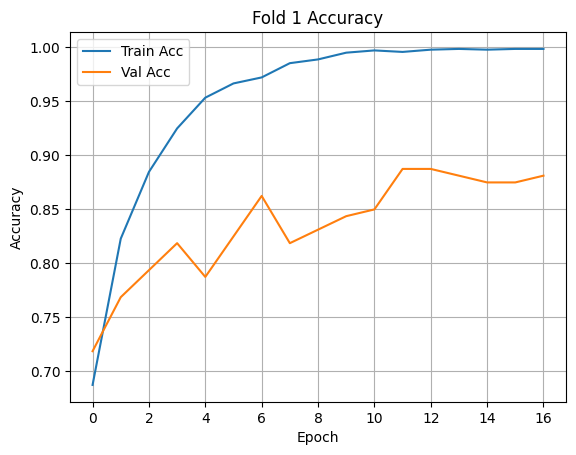

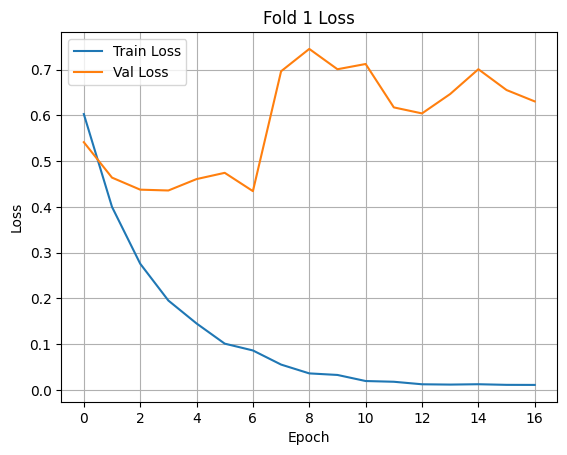

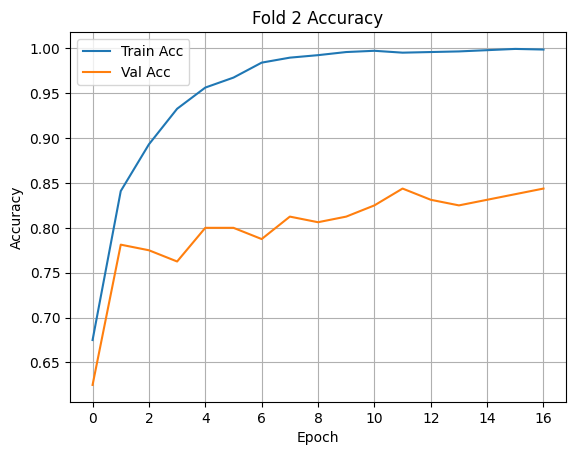

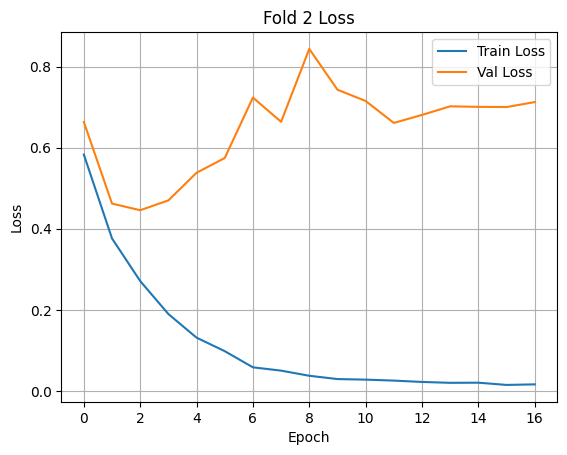

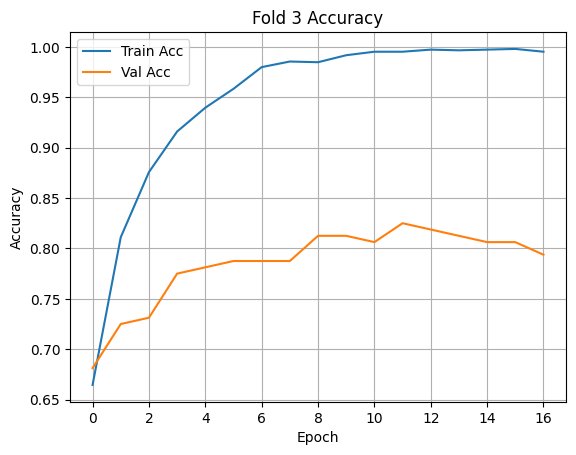

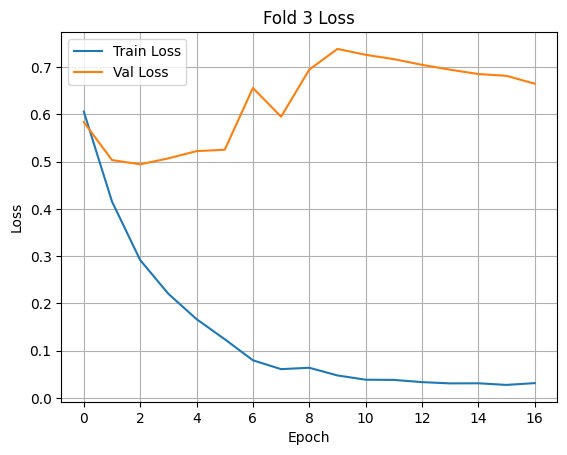

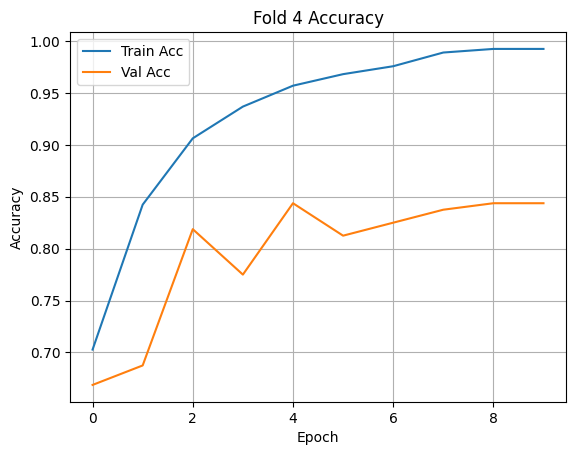

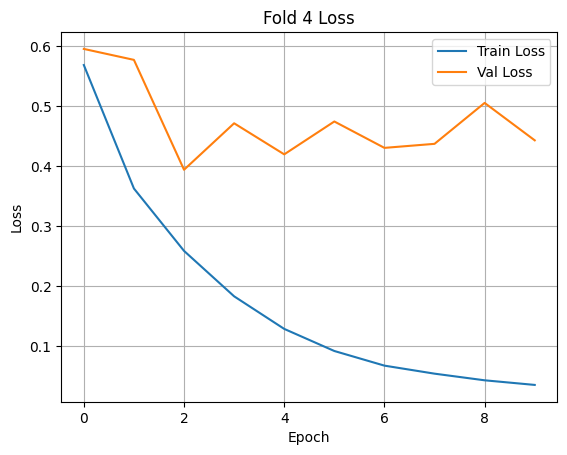

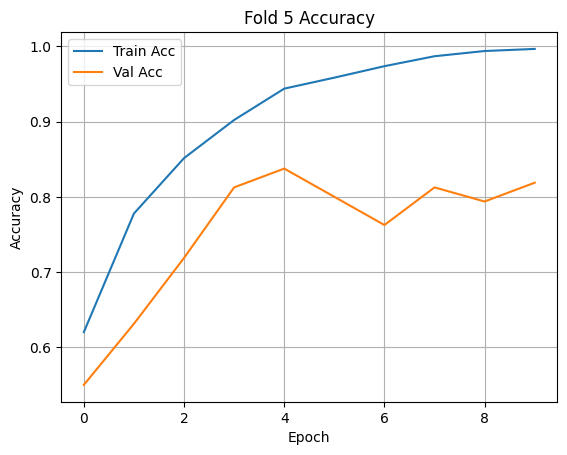

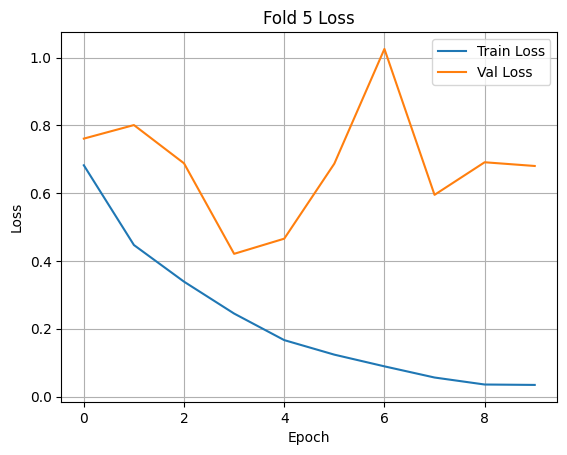

In [10]:
for i, hist in enumerate(all_histories, 1):
    plt.figure()
    plt.plot(hist['accuracy'], label='Train Acc')
    plt.plot(hist['val_accuracy'], label='Val Acc')
    plt.title(f'Fold {i} Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure()
    plt.plot(hist['loss'], label='Train Loss')
    plt.plot(hist['val_loss'], label='Val Loss')
    plt.title(f'Fold {i} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()


In [11]:
# Save mô hình fold cuối cùng
model.save("mobilenetv2_hmm_faceplus_final.h5")


/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [12]:
results_df = pd.DataFrame(results)
print("📊 Kết quả trung bình:")
print(results_df.mean(numeric_only=True))
results_df


📊 Kết quả trung bình:
fold         3.000000
accuracy     0.631500
precision    0.422531
recall       0.449000
f1           0.434025
auc          0.931070
dtype: float64


,fold,accuracy,precision,recall,f1,auc
0,1,0.5025,0.502513,0.500,0.501253,0.937550
1,2,0.8300,0.843750,0.810,0.826531,0.919175
2,3,0.5000,0.000000,0.000,0.000000,0.956450
3,4,0.5000,0.000000,0.000,0.000000,0.913575
4,5,0.8250,0.766393,0.935,0.842342,0.928600


In [13]:
import pandas as pd

# Giả sử results đã có và bạn đã tạo results_df
results_df = pd.DataFrame(results)

# Tính các chỉ số
accuracy_mean = results_df['accuracy'].mean()
accuracy_std = results_df['accuracy'].std()  # dùng sample std (chia cho n-1)
accuracy_range = results_df['accuracy'].max() - results_df['accuracy'].min()
accuracy_cv_percent = (accuracy_std / accuracy_mean) * 100

# In kết quả
print("📊 Kết quả trung bình:")
print(results_df.mean(numeric_only=True))

print(f"\n✅ CV Accuracy (Mean Accuracy): {accuracy_mean:.4f}")
print(f"📈 Range Accuracy: {accuracy_range:.4f}")
print(f"📉 Accuracy CV% (std/mean): {accuracy_cv_percent:.2f}%")

# Hiển thị bảng kết quả nếu cần
results_df


📊 Kết quả trung bình:
fold         3.000000
accuracy     0.631500
precision    0.422531
recall       0.449000
f1           0.434025
auc          0.931070
dtype: float64

✅ CV Accuracy (Mean Accuracy): 0.6315
📈 Range Accuracy: 0.3300
📉 Accuracy CV% (std/mean): 28.33%


,fold,accuracy,precision,recall,f1,auc
0,1,0.5025,0.502513,0.500,0.501253,0.937550
1,2,0.8300,0.843750,0.810,0.826531,0.919175
2,3,0.5000,0.000000,0.000,0.000000,0.956450
3,4,0.5000,0.000000,0.000,0.000000,0.913575
4,5,0.8250,0.766393,0.935,0.842342,0.928600
